# Se importan las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import ast
import requests
import sys

# Se cargan los datset solicitados

In [2]:
movie = pd.read_csv("datasets/movies_dataset.csv")
credits = pd.read_csv("datasets/credits.csv")

C:\Users\Sergio\AppData\Local\Temp\ipykernel_47864\2045859923.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie = pd.read_csv("datasets/movies_dataset.csv")


# Visualizacion de los dataset

In [3]:
movie.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [5]:
movie.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [6]:
credits.dtypes

cast    object
crew    object
id       int64
dtype: object

# Desanidado de las columnas que contienen diccionarios o listas
En este caso en dicha columnas lo que hago es buscar los datos que voy a necesitar y los sobreescribo en la columna

In [7]:
# Funcion para extraer el nombre de la coleccion de las peliculas con franquicia
def coleccion(dato):
    if pd.notnull(dato):
        try:
            datos = eval(dato)
            nombre = datos['name']
            return (nombre)
        except (SyntaxError, KeyError, TypeError):
            pass  
    return dato
# Funcion para extrar los datos que necesito de las columnas genres, production_companies y production_countries
def extraer(datos):
    try:
        listaDatos = ast.literal_eval(datos)
        if isinstance(listaDatos, list):
            return [dato['name'] for dato in listaDatos]
    except (SyntaxError, ValueError):
        pass
    return []
    
movie['belongs_to_collection'] = movie['belongs_to_collection'].apply(coleccion)

columnas = ['genres','production_companies', 'production_countries']
for columna in columnas:
    movie[columna] = movie[columna].fillna('[]')
    movie[columna] = movie[columna].apply(extraer)

In [8]:
# De cast solo me interesan los nombres de los actores
def actor(casts):
    try:
        cast_list = eval(casts)  
        nombre = [cast['name'] for cast in cast_list]
        return nombre
    except (SyntaxError, ValueError):
        return []

credits['cast'] = credits['cast'].apply(actor)

In [9]:
# De crew solo me interesa el nombre del director
def director(crew):
    try:
        crew_list = eval(crew) 
        for member in crew_list:
            if member['job'] == 'Director':
                return member['name']
        return None  
    except (SyntaxError, ValueError):
        return None

credits['crew'] = credits['crew'].apply(director)

# Mostrar los DataFrames con los datos actualizados

In [10]:
movie.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,Toy Story Collection,30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,Grumpy Old Men Collection,0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,Father of the Bride Collection,0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [11]:

credits.head()

,cast,crew,id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston,8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch,15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker,31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer,11862


In [12]:
# Rellenar los valores nulos de las columnas "revenue" y "budget" con el número 0
movie["revenue"].fillna(0, inplace=True)
movie["budget"].fillna(0, inplace=True)

In [13]:
# Convertir las columnas "budget" y "revenue" a valores numéricos
movie["budget"] = pd.to_numeric(movie["budget"], errors="coerce")
movie["revenue"] = pd.to_numeric(movie["revenue"], errors="coerce")

In [14]:
# Calcular el retorno de inversión y crear la columna 'return'
movie['return'] = movie['revenue'] / movie['budget']
movie['return'].fillna(0, inplace=True)  # Rellenar los valores NaN con 0
movie.replace([np.inf, -np.inf], 0, inplace=True)

In [15]:
# Eliminar los valores nulos en la columna "release_date"
movie.dropna(subset=["release_date"], inplace=True)

In [16]:
# Las fechas, deberán tener el formato AAAA-mm-dd, además se crea la columna release_year donde extraerán el año de la fecha de estreno.
movie["release_date"] = pd.to_datetime(movie["release_date"], errors="coerce").dt.strftime('%Y-%m-%d')
movie["release_year"] = pd.to_datetime(movie["release_date"], errors="coerce").dt.year
movie["release_year"] = movie["release_year"].astype(float).astype(pd.Int32Dtype())


In [17]:
# Columnas a eliminar
columnas_a_eliminar = ['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage','spoken_languages']
movie.drop(columns=columnas_a_eliminar, inplace=True)

In [20]:
# Se crea el Dataset peliculas con la combinacion de movie y credits por el id
movie['id'] = movie['id'].astype(str)
credits['id'] = credits['id'].astype(str)
peliculas = pd.merge(movie, credits, on='id', how='inner')


In [21]:
# Visualizacion del dataset peliculas
peliculas.head()

,belongs_to_collection,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,...,runtime,status,tagline,title,vote_average,vote_count,return,release_year,cast,crew
0,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,...,81.0,Released,NaN,Toy Story,7.7,5415.0,12.451801,1995,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,NaN,65000000.0,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,...,104.0,Released,Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,4.043035,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,Grumpy Old Men Collection,0.0,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,...,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,0.000000,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,NaN,16000000.0,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,...,127.0,Released,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,5.090760,1995,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,Father of the Bride Collection,0.0,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,...,106.0,Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,0.000000,1995,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer


In [22]:
peliculas.dtypes

belongs_to_collection     object
budget                   float64
genres                    object
id                        object
original_language         object
overview                  object
popularity                object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
status                    object
tagline                   object
title                     object
vote_average             float64
vote_count               float64
return                   float64
release_year               Int32
cast                      object
crew                      object
dtype: object

In [23]:
# renombro algunas columnas para mejor comprencion y tambien cambio los tipos de variables en la que hace falta
peliculas.rename(columns={'belongs_to_collection': 'franquicia', 'production_companies': 'productora', 'production_countries': 'pais','original_language': 'idioma', 'spoken_languages': 'lenguajes_adicionales', 'tagline': 'eslogan', 'crew': 'director'}, inplace=True)

peliculas["id"] = peliculas["id"].astype(int)
peliculas["popularity"] = peliculas["popularity"].astype(float)
peliculas["vote_count"] = peliculas["vote_count"].astype(int)

# Limpieza adicional de datos

In [24]:
#cantidad de filas duplicadas 
peliculas.duplicated(subset='id').sum()

106

In [25]:
#se revisan las filas con id duplicado
peliculas[peliculas.id.duplicated(keep=False)].sort_values(by="id") 

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,...,runtime,status,eslogan,title,vote_average,vote_count,return,release_year,cast,director
25929,NaN,0.0,"[Drama, Horror, Science Fiction, Mystery]",3057,en,Frankenstein is a 2004 U.S. television miniser...,1.215853,"[Hallmark Entertainment, RTL2]","[Germany, Slovakia, United States of America]",2004-10-05,...,115.0,Released,NaN,Frankenstein,6.0,14,0.00000,2004,"[Luke Goss, Alec Newman, Julie Delpy, William ...",Kevin Connor
25930,NaN,0.0,"[Drama, Horror, Science Fiction, Mystery]",3057,en,Frankenstein is a 2004 U.S. television miniser...,1.215853,"[Hallmark Entertainment, RTL2]","[Germany, Slovakia, United States of America]",2004-10-05,...,115.0,Released,NaN,Frankenstein,6.0,14,0.00000,2004,"[Luke Goss, Alec Newman, Julie Delpy, William ...",Kevin Connor
5887,NaN,30000000.0,"[Comedy, Crime, Drama, Romance, Thriller]",4912,en,"Television made him famous, but his biggest hi...",11.331072,"[Miramax Films, Allied Filmmakers, Mad Chance]",[United States of America],2002-12-30,...,113.0,Released,Some things are better left top secret.,Confessions of a Dangerous Mind,6.6,281,1.10046,2002,"[Sam Rockwell, Drew Barrymore, Julia Roberts, ...",George Clooney
5888,NaN,30000000.0,"[Comedy, Crime, Drama, Romance, Thriller]",4912,en,"Television made him famous, but his biggest hi...",11.331072,"[Miramax Films, Allied Filmmakers, Mad Chance]",[United States of America],2002-12-30,...,113.0,Released,Some things are better left top secret.,Confessions of a Dangerous Mind,6.6,281,1.10046,2002,"[Sam Rockwell, Drew Barrymore, Julia Roberts, ...",George Clooney
5889,NaN,30000000.0,"[Comedy, Crime, Drama, Romance, Thriller]",4912,en,"Television made him famous, but his biggest hi...",7.645827,"[Miramax Films, Allied Filmmakers, Mad Chance]",[United States of America],2002-12-30,...,113.0,Released,Some things are better left top secret.,Confessions of a Dangerous Mind,6.6,281,1.10046,2002,"[Sam Rockwell, Drew Barrymore, Julia Roberts, ...",George Clooney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24206,NaN,0.0,"[Comedy, Drama]",265189,sv,"While holidaying in the French Alps, a Swedish...",12.165685,"[Motlys, Coproduction Office, Film i Väst]","[Norway, Sweden, France]",2014-08-15,...,118.0,Released,NaN,Force Majeure,6.8,255,0.00000,2014,"[Lisa Loven Kongsli, Johannes Bah Kuhnke, Clar...",Ruben Östlund
33226,NaN,980000.0,"[Drama, Fantasy]",298721,th,"In a hospital, ten soldiers are being treated ...",2.535419,"[Match Factory, The, Louverture Films, Tordenf...","[United Kingdom, United States of America, Fra...",2015-09-02,...,122.0,Released,NaN,Cemetery of Splendour,4.4,50,0.00000,2015,"[Jenjira Pongpas, Banlop Lomnoi, Jarinpattra R...",Apichatpong Weerasethakul
33227,NaN,980000.0,"[Drama, Fantasy]",298721,th,"In a hospital, ten soldiers are being treated ...",2.535419,"[Match Factory, The, Louverture Films, Tordenf...","[United Kingdom, United States of America, Fra...",2015-09-02,...,122.0,Released,NaN,Cemetery of Splendour,4.4,50,0.00000,2015,"[Jenjira Pongpas, Banlop Lomnoi, Jarinpattra R...",Apichatpong Weerasethakul
33228,NaN,980000.0,"[Drama, Fantasy]",298721,th,"In a hospital, ten soldiers are being treated ...",2.535419,"[Match Factory, The, Louverture Films, Tordenf...","[United Kingdom, United States of America, Fra...",2015-09-02,...,122.0,Released,NaN,Cemetery of Splendour,4.4,50,0.00000,2015,"[Jenjira Pongpas, Banlop Lomnoi, Jarinpattra R...",Apichatpong Weerasethakul


In [26]:
#se eliminan las filas con id duplicado conservando las últimas cargadas en la base
peliculas.drop_duplicates(subset="id", keep="last", inplace=True) 

In [28]:
peliculas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45345 entries, 0 to 45450
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   franquicia    4485 non-null   object 
 1   budget        45345 non-null  float64
 2   genres        45345 non-null  object 
 3   id            45345 non-null  int32  
 4   idioma        45334 non-null  object 
 5   overview      44404 non-null  object 
 6   popularity    45345 non-null  float64
 7   productora    45345 non-null  object 
 8   pais          45345 non-null  object 
 9   release_date  45345 non-null  object 
 10  revenue       45345 non-null  float64
 11  runtime       45099 non-null  float64
 12  status        45265 non-null  object 
 13  eslogan       20387 non-null  object 
 14  title         45345 non-null  object 
 15  vote_average  45345 non-null  float64
 16  vote_count    45345 non-null  int32  
 17  return        45345 non-null  float64
 18  release_year  45345 non-nu

In [30]:
#se revisa la cantidad de valores faltantes para cada feature
peliculas.isna().sum() 

franquicia      40860
budget              0
genres              0
id                  0
idioma             11
overview          941
popularity          0
productora          0
pais                0
release_date        0
revenue             0
runtime           246
status             80
eslogan         24958
title               0
vote_average        0
vote_count          0
return              0
release_year        0
cast                0
director          835
dtype: int64

In [31]:
# reemplazar valores NaN por cadenas vacías
peliculas.fillna('', inplace=True)


In [34]:
# Para obtener menos consumo de memoria en el sistema de recomendacion elimino las filas en la que el status no sea "Released" y ademas elimino la columna status
peliculas = peliculas[peliculas['status'] == 'Released']

peliculas.drop('status', axis=1, inplace=True)


In [35]:
peliculas

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,revenue,runtime,eslogan,title,vote_average,vote_count,return,release_year,cast,director
0,Toy Story Collection,30000000.0,"[Animation, Comedy, Family]",862,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,,Toy Story,7.7,5415,12.451801,1995,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter
1,,65000000.0,"[Adventure, Fantasy, Family]",8844,en,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,Roll the dice and unleash the excitement!,Jumanji,6.9,2413,4.043035,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",Joe Johnston
2,Grumpy Old Men Collection,0.0,"[Romance, Comedy]",15602,en,A family wedding reignites the ancient feud be...,11.712900,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92,0.000000,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",Howard Deutch
3,,16000000.0,"[Comedy, Drama, Romance]",31357,en,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34,5.090760,1995,"[Whitney Houston, Angela Bassett, Loretta Devi...",Forest Whitaker
4,Father of the Bride Collection,0.0,[Comedy],11862,en,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173,0.000000,1995,"[Steve Martin, Diane Keaton, Martin Short, Kim...",Charles Shyer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45446,,0.0,"[Drama, Action, Romance]",30840,en,"Yet another version of the classic epic, with ...",5.683753,"[Westdeutscher Rundfunk (WDR), Working Title F...","[Canada, Germany, United Kingdom, United State...",1991-05-13,0.0,104.0,,Robin Hood,5.7,26,0.000000,1991,"[Patrick Bergin, Uma Thurman, David Morrissey,...",John Irvin
45447,,0.0,[Drama],111109,tl,An artist struggles to finish his work while a...,0.178241,[Sine Olivia],[Philippines],2011-11-17,0.0,360.0,,Century of Birthing,9.0,3,0.000000,2011,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...",Lav Diaz
45448,,0.0,"[Action, Drama, Thriller]",67758,en,"When one of her hits goes wrong, a professiona...",0.903007,[American World Pictures],[United States of America],2003-08-01,0.0,90.0,A deadly game of wits.,Betrayal,3.8,6,0.000000,2003,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...",Mark L. Lester
45449,,0.0,[],227506,en,"In a small town live two brothers, one a minis...",0.003503,[Yermoliev],[Russia],1917-10-21,0.0,87.0,,Satan Triumphant,0.0,0,0.000000,1917,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",Yakov Protazanov


# Análisis exploratorio de los datos:

In [154]:
# Estadísticas descriptivas para columnas numéricas
peliculas.describe()

,budget,id,popularity,revenue,vote_average,vote_count,return,release_year
count,4.534500e+04,45345.000000,45345.000000,4.534500e+04,45345.000000,45345.000000,4.534500e+04,45345.000000
mean,4.232673e+06,108035.740479,2.926052,1.123390e+07,5.624320,110.137766,6.604937e+02,1991.882280
std,1.744391e+07,112180.079341,6.010770,6.441058e+07,1.915178,491.904429,7.471882e+04,24.053016
min,0.000000e+00,2.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1874.000000
25%,0.000000e+00,26390.000000,0.388844,0.000000e+00,5.000000,3.000000,0.000000e+00,1978.000000
50%,0.000000e+00,59852.000000,1.130300,0.000000e+00,6.000000,10.000000,0.000000e+00,2001.000000
75%,0.000000e+00,156597.000000,3.689610,0.000000e+00,6.800000,34.000000,0.000000e+00,2010.000000
max,3.800000e+08,469172.000000,547.488298,2.787965e+09,10.000000,14075.000000,1.239638e+07,2020.000000


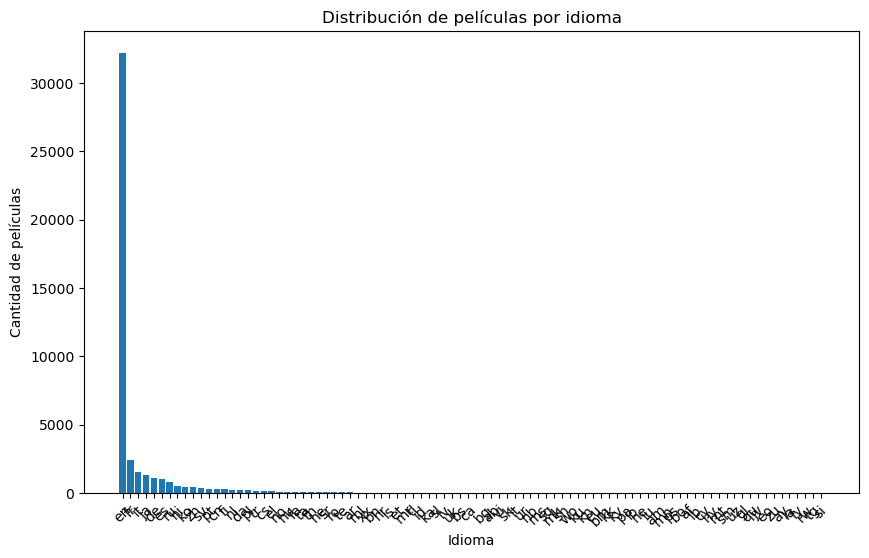

In [155]:
# Visualización de la distribución de películas por idioma
idioma_counts = peliculas['idioma'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(idioma_counts.index, idioma_counts.values)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de películas')
plt.title('Distribución de películas por idioma')
plt.xticks(rotation=45)
plt.show()


C:\Users\Sergio\AppData\Local\Temp\ipykernel_12176\1419290655.py:10: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  idiomas_frecuentes = top_idiomas.append(otros_idiomas)


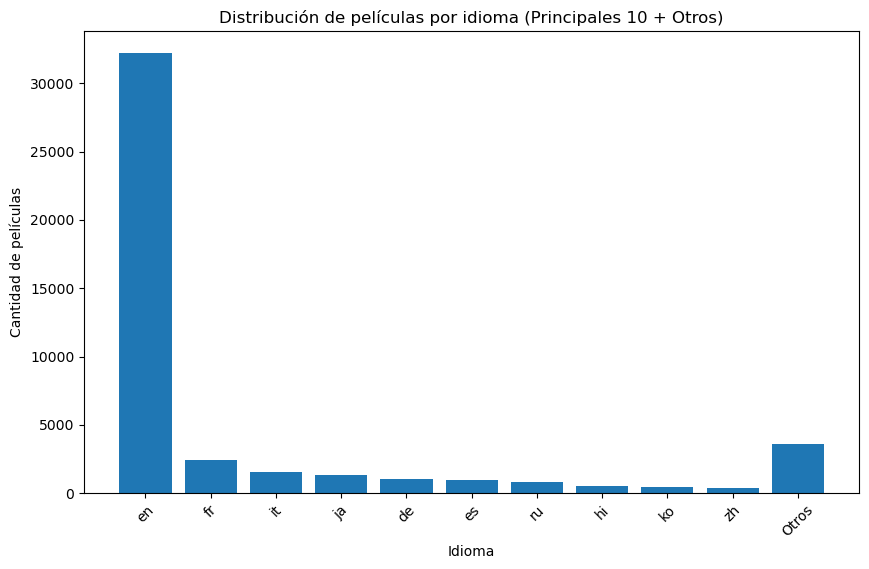

In [162]:
# Visualización de la distribución de películas por idioma con agrupación de idiomas menos frecuentes en "Otros"
idioma_counts = peliculas['idioma'].value_counts()

# Establecer el número de idiomas principales a mostrar
num_top_idiomas = 10

# Obtener los idiomas más frecuentes y agrupar el resto en "Otros"
top_idiomas = idioma_counts[:num_top_idiomas]
otros_idiomas = pd.Series(idioma_counts[num_top_idiomas:].sum(), index=['Otros'])
idiomas_frecuentes = top_idiomas.append(otros_idiomas)

plt.figure(figsize=(10, 6))
plt.bar(idiomas_frecuentes.index, idiomas_frecuentes.values)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de películas')
plt.title(f'Distribución de películas por idioma (Principales {num_top_idiomas} + Otros)')
plt.xticks(rotation=45)
plt.show()


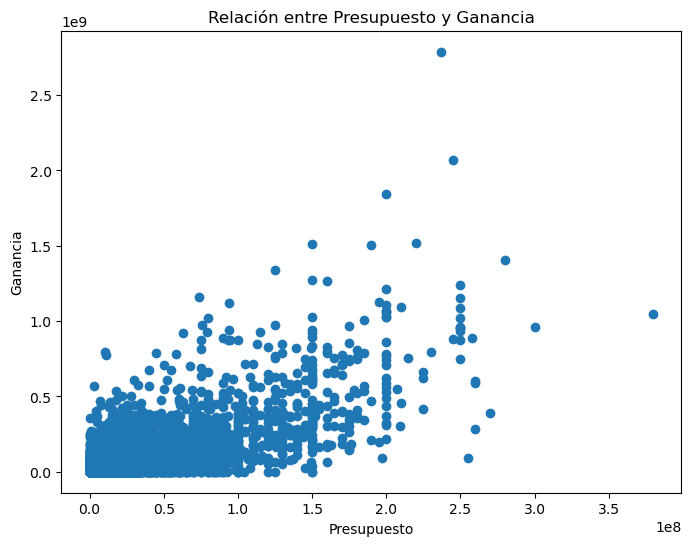

In [156]:
# Visualización de la relación entre presupuesto y ganancia
plt.figure(figsize=(8, 6))
plt.scatter(peliculas['budget'], peliculas['revenue'])
plt.xlabel('Presupuesto')
plt.ylabel('Ganancia')
plt.title('Relación entre Presupuesto y Ganancia')
plt.show()


In [160]:
%pip install wordcloud

  Using cached wordcloud-1.9.2-cp39-cp39-win_amd64.whl (153 kB)
Note: you may need to restart the kernel to use updated packages.


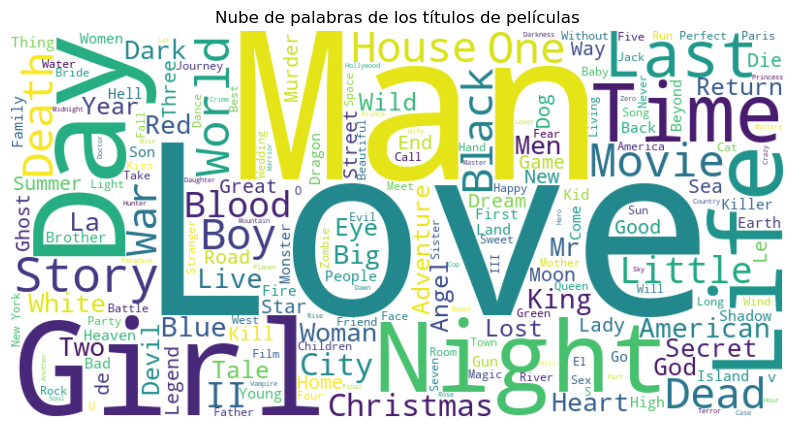

In [161]:
from wordcloud import WordCloud

# Concatenar todos los títulos en un solo texto
all_titles = ' '.join(peliculas['title'])

# Crear una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)

# Visualización de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de los títulos de películas')
plt.show()


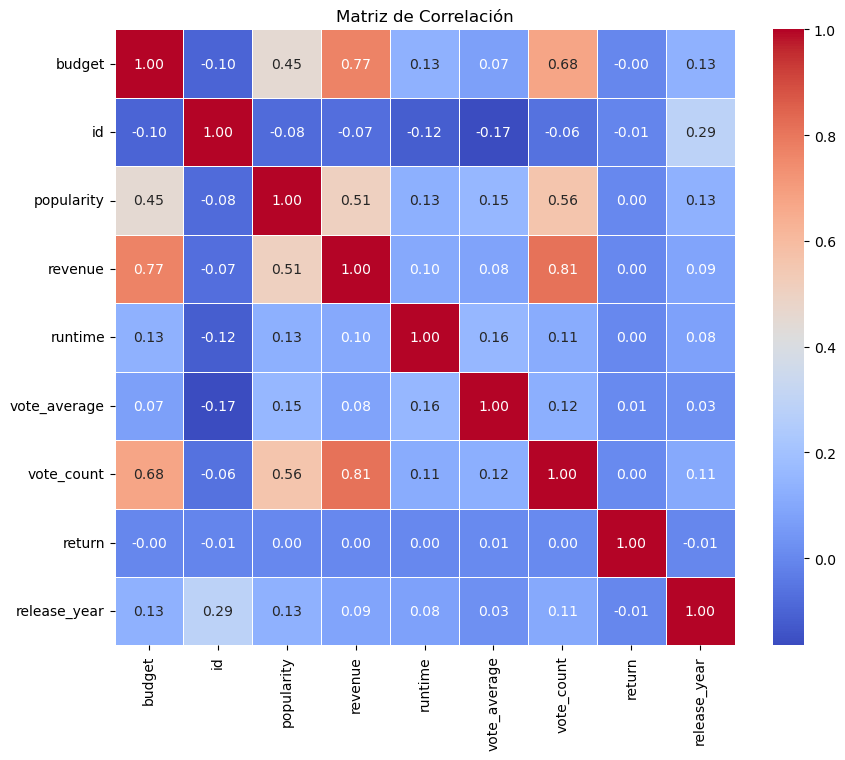

In [163]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset "peliculas"
peliculas = pd.read_csv('datasets/peliculas.csv')

# Reemplazar valores NaN por cadenas vacías en las columnas relevantes
peliculas['franquicia'].fillna('', inplace=True)
peliculas['genres'].fillna('', inplace=True)
peliculas['idioma'].fillna('', inplace=True)
peliculas['eslogan'].fillna('', inplace=True)

# Crear la matriz de correlación
matriz_correlacion = peliculas.corr()

# Visualizar la matriz de correlación en un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()


In [164]:
import pandas as pd

# Cargar el dataset "peliculas"
peliculas = pd.read_csv('datasets/peliculas.csv')

# Reemplazar valores NaN por cadenas vacías en las columnas relevantes
peliculas['franquicia'].fillna('', inplace=True)
peliculas['genres'].fillna('', inplace=True)
peliculas['idioma'].fillna('', inplace=True)
peliculas['eslogan'].fillna('', inplace=True)

# Crear la matriz de correlación
matriz_correlacion = peliculas.corr()

# Imprimir la matriz de correlación
print(matriz_correlacion)


                budget        id  popularity   revenue   runtime  \
budget        1.000000 -0.101274    0.449590  0.768811  0.134706   
id           -0.101274  1.000000   -0.082435 -0.070987 -0.119359   
popularity    0.449590 -0.082435    1.000000  0.506203  0.129628   
revenue       0.768811 -0.070987    0.506203  1.000000  0.103969   
runtime       0.134706 -0.119359    0.129628  0.103969  1.000000   
vote_average  0.073159 -0.165114    0.153714  0.083811  0.156642   
vote_count    0.676668 -0.064514    0.559973  0.812019  0.113527   
return       -0.002137 -0.006759    0.003216  0.000791  0.000891   
release_year  0.131654  0.286999    0.131637  0.088364  0.078778   

              vote_average  vote_count    return  release_year  
budget            0.073159    0.676668 -0.002137      0.131654  
id               -0.165114   -0.064514 -0.006759      0.286999  
popularity        0.153714    0.559973  0.003216      0.131637  
revenue           0.083811    0.812019  0.000791      0.088

In [165]:
import pandas as pd

# Cargar el dataset "peliculas" si aún no lo tienes cargado
peliculas = pd.read_csv('datasets/peliculas.csv')

# Crear la tabla de contingencia entre franquicia y género
tabla_contingencia = pd.crosstab(peliculas['franquicia'], peliculas['genres'])

# Visualizar la tabla de contingencia
print(tabla_contingencia)


genres                                ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime']  \
franquicia                                                                                      
... Has Fallen Collection                                                             0         
00 Schneider Filmreihe                                                                0         
08/15 Collection                                                                      0         
100 Girls Collection                                                                  0         
101 Dalmatians (Animated) Collection                                                  0         
...                                                                                 ...         
Сказки Чуковского                                                                     0         
Чебурашка и крокодил Гена                                                             0         
Что Творят мужчины! (Коллекция

In [33]:
peliculas.to_csv("datasets/peliculas.csv", index=False)

In [67]:
# Crear un nuevo DataFrame "peliculas_procesadas" con las columnas relevantes
peliculas_procesadas = peliculas[['id','title', 'franquicia', 'genres']]

In [70]:
peliculas_procesadas

,id,title,franquicia,genres
0,862,Toy Story,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,8844,Jumanji,,"['Adventure', 'Fantasy', 'Family']"
2,15602,Grumpier Old Men,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,31357,Waiting to Exhale,,"['Comedy', 'Drama', 'Romance']"
4,11862,Father of the Bride Part II,Father of the Bride Collection,['Comedy']
...,...,...,...,...
45446,30840,Robin Hood,,"['Drama', 'Action', 'Romance']"
45447,111109,Century of Birthing,,['Drama']
45448,67758,Betrayal,,"['Action', 'Drama', 'Thriller']"
45449,227506,Satan Triumphant,,[]


In [73]:
peliculas[peliculas['id'] == 227506]

,franquicia,budget,genres,id,idioma,overview,popularity,productora,pais,release_date,...,status,eslogan,title,vote_average,vote_count,return,release_year,cast,director,combined_features
45449,,0.0,[],227506,en,"In a small town live two brothers, one a minis...",0.003503,[Yermoliev],[Russia],1917-10-21,...,Released,,Satan Triumphant,0.0,0,0.0,1917,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",Yakov Protazanov,[]


In [74]:
# Filtrar el DataFrame para obtener la fila con el ID 227506
fila_227506 = peliculas[peliculas['id'] == 227506]

# Obtener el valor de la columna "genres" en la fila con el ID 227506
valor_genres = fila_227506['genres'].values[0]

print("Valor de 'genres' en la fila con ID 227506:", valor_genres)


Valor de 'genres' en la fila con ID 227506: []


In [75]:
# Filtrar las filas donde la columna "genres" es una lista vacía []
filas_genres_vacias = peliculas[peliculas['genres'].apply(lambda x: x == [])]

# Mostrar todas las columnas de las filas con genres vacías
print(filas_genres_vacias)


Empty DataFrame
Columns: [franquicia, budget, genres, id, idioma, overview, popularity, productora, pais, release_date, revenue, runtime, status, eslogan, title, vote_average, vote_count, return, release_year, cast, director, combined_features]
Index: []

[0 rows x 22 columns]


In [76]:
# Filtrar las filas donde la columna "genres" está vacía o es nula
filas_genres_vacias = peliculas[peliculas['genres'].isnull() | peliculas['genres'].apply(lambda x: x == [])]

# Mostrar todas las columnas de las filas con genres vacías
print(filas_genres_vacias)


Empty DataFrame
Columns: [franquicia, budget, genres, id, idioma, overview, popularity, productora, pais, release_date, revenue, runtime, status, eslogan, title, vote_average, vote_count, return, release_year, cast, director, combined_features]
Index: []

[0 rows x 22 columns]


In [150]:
# Eliminar filas con valores nulos o vacíos en alguna columna
peliculas_procesadas = peliculas_procesadas.dropna(how='any')

In [69]:
# Eliminar filas con listas vacías en la columna "genres"
peliculas_procesadas = peliculas_procesadas.dropna(subset=['genres'])

In [81]:
# Crear un nuevo DataFrame con las columnas deseadas y las primeras 1000 filas del DataFrame original
peliculas_procesadas = peliculas[['id', 'title', 'franquicia', 'genres']].head(1000)

# Mostrar el nuevo DataFrame
peliculas_procesadas


,id,title,franquicia,genres
0,862,Toy Story,Toy Story Collection,"['Animation', 'Comedy', 'Family']"
1,8844,Jumanji,,"['Adventure', 'Fantasy', 'Family']"
2,15602,Grumpier Old Men,Grumpy Old Men Collection,"['Romance', 'Comedy']"
3,31357,Waiting to Exhale,,"['Comedy', 'Drama', 'Romance']"
4,11862,Father of the Bride Part II,Father of the Bride Collection,['Comedy']
...,...,...,...,...
1004,29682,So Dear to My Heart,,"['Animation', 'Drama', 'Family']"
1005,8367,Robin Hood: Prince of Thieves,,['Adventure']
1006,433,Mary Poppins,,"['Comedy', 'Family', 'Fantasy']"
1007,11360,Dumbo,,"['Animation', 'Family']"


In [79]:
peliculas_procesadas.to_csv('datasets/peliculas_procesadas.csv', index=False)